In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
from scipy import stats

custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.dpi": 300,
    "savefig.dpi": 600,
}
sns.set(rc=custom_params, style="ticks", font_scale=1)

In [10]:
#combine top and next bins
for rep in ["rep1", "rep2"]:
    df = pd.read_csv("/projects/brpe7306/fab-library-barcoding/CDRH3_Output/"+rep+"_combined.csv")
    df_grouped = df.groupby(['Barcode', 'Variant', 'Concentration', 'ref_barcode', 'ref_total'])[['Rijk', 'Rjk', 'Nk', 'Njk']].sum().reset_index()
    df_grouped = pd.merge(df_grouped, df.groupby(['Barcode', 'Variant', 'Concentration']).agg({'Gj': 'min', 'Hj': 'max'}).reset_index(), 
                          on=['Barcode', 'Variant', 'Concentration'])
    df_grouped['Bin'] = "top25"
    df_collapsed = df_grouped
    df_collapsed['pij'] = (df_collapsed['Njk']/df_collapsed['Nk'])*(df_collapsed['Rijk']/df_collapsed['Rjk'])/(df_collapsed['ref_barcode']/df_collapsed['ref_total'])
    df_collapsed = df_collapsed[df_collapsed['ref_barcode'] >= 100]
    pivot_df = df_collapsed.pivot(index='Barcode', columns='Concentration', values='pij')
    merged_df = pd.merge(pivot_df, df_collapsed[['Barcode', 'Variant', 'ref_barcode']].drop_duplicates(), on='Barcode')
    merged_df.columns = [str(col) + 'nM' if str(col).replace('.', '', 1).isdigit() else str(col) for col in merged_df.columns]
    merged_df['Gene'] = merged_df['Variant'].str.split('>').str[0]
    merged_df = merged_df.rename(columns={'ref_barcode': 'ref_count'})
    merged_df = merged_df.sort_values('2000.0nM', ascending=False)
    merged_df['Silent'] = merged_df['Variant'].str.contains(r'([A-Z])(\d+)\1')
    merged_df['num_mutations'] = merged_df['Variant'].str.count(';') + 1
    merged_df.loc[merged_df['Variant'].str.contains('WT|:$', regex=True), 'num_mutations'] = 0

    if rep == "rep1":
        merged_df = merged_df[['Barcode', 'Variant', 'Gene', 'Silent', 'num_mutations', '2.5nM', '50.0nM', '100.0nM', '500.0nM', '1000.0nM', '2000.0nM', 'ref_count']]
        # removed merged_df['50.0nM']/50 + 
        merged_df['Score'] = -np.log(merged_df['50.0nM']/50 + merged_df['100.0nM']/100 + merged_df['500.0nM']/500 + merged_df['1000.0nM']/1000 + merged_df['2000.0nM']/2000)
    elif rep == 'rep2':
        merged_df = merged_df[['Barcode', 'Variant', 'Gene', 'Silent', 'num_mutations', '2.5nM', '100.0nM', '500.0nM', '1000.0nM', '2000.0nM', 'ref_count']]
        merged_df['Score'] = -np.log(merged_df['100.0nM']/100 + merged_df['500.0nM']/500 + merged_df['1000.0nM']/1000 + merged_df['2000.0nM']/2000)
    merged_df.to_csv("bc_pij_top10bins_"+rep+".csv", index=False, float_format='%.6f')


/tmp/ipykernel_1254757/2387409688.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  merged_df['Silent'] = merged_df['Variant'].str.contains(r'([A-Z])(\d+)\1')
/tmp/ipykernel_1254757/2387409688.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  merged_df['Silent'] = merged_df['Variant'].str.contains(r'([A-Z])(\d+)\1')


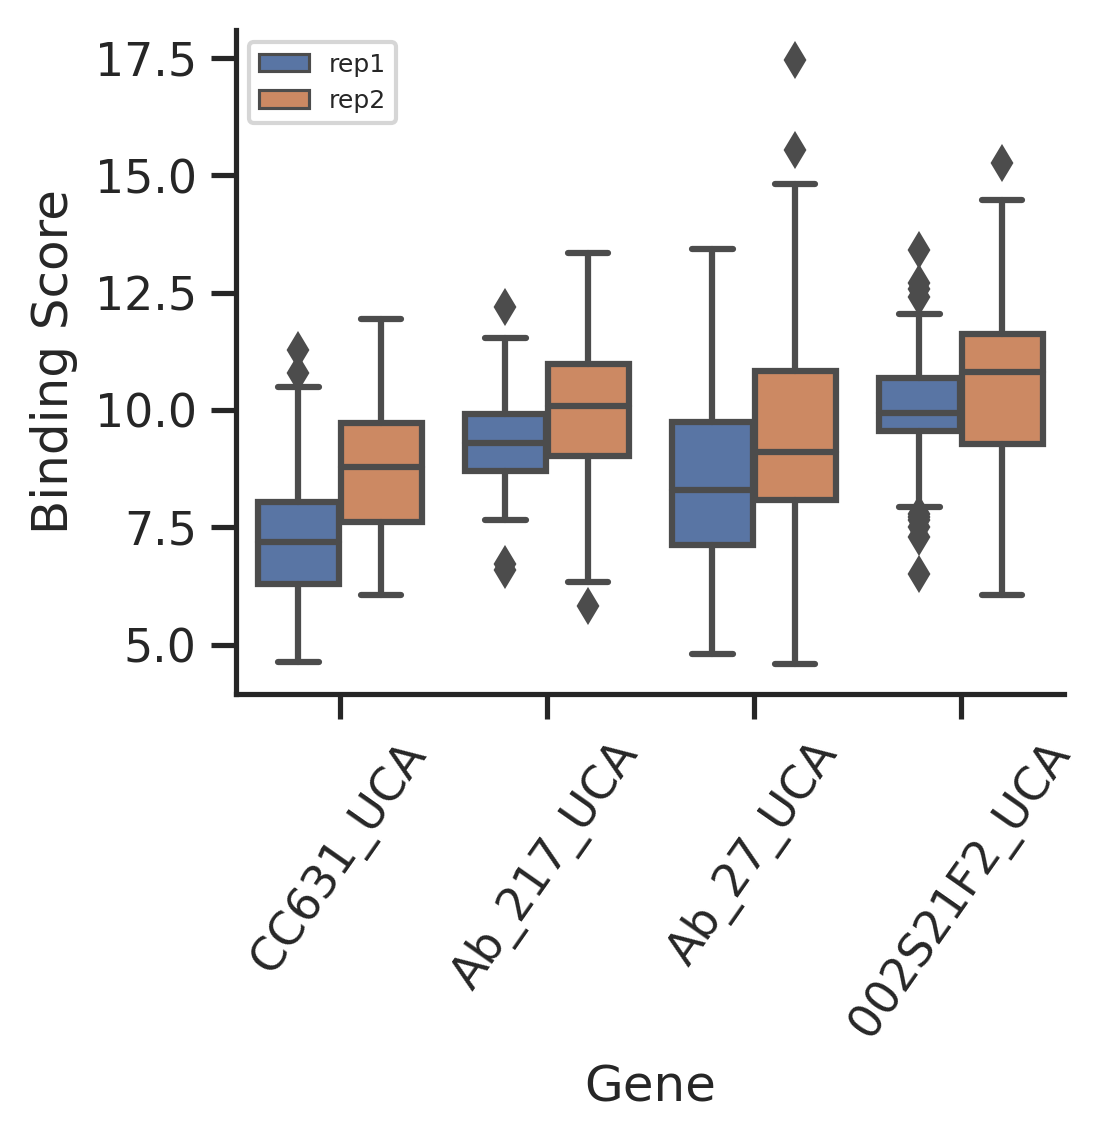

                                                mean            count      
rep                                             rep1       rep2  rep1  rep2
Variant                                                                    
002S21F2_UCA>VH:D74N-AAC;S119S-TCC          9.231977   8.307024   1.0   1.0
002S21F2_UCA>VH:F106C-TGC;V116I-ATC        10.242545  10.501454   1.0   1.0
002S21F2_UCA>VH:F106F-TTT                  10.117914  10.489330  13.0   7.0
002S21F2_UCA>VH:F106I-ATC                   8.519972   8.951518   1.0   3.0
002S21F2_UCA>VH:F106L-CTC                   9.939389  15.263699   5.0   1.0
...                                              ...        ...   ...   ...
CC631_UCA>VH:W99C-TGT;S105N-AAT             9.708306  10.416847   2.0   2.0
CC631_UCA>VH:W99D-GAT;S105F-TTT;I106F-TTT   9.165159  10.152451   7.0   9.0
CC631_UCA>VH:W99L-CTT;S105L-CTG;I106V-GTT   9.579550  10.455918   9.0   6.0
CC631_UCA>VH:W99S-TCG                       8.215252   8.995564   1.0   6.0
CC631_UCA>VH

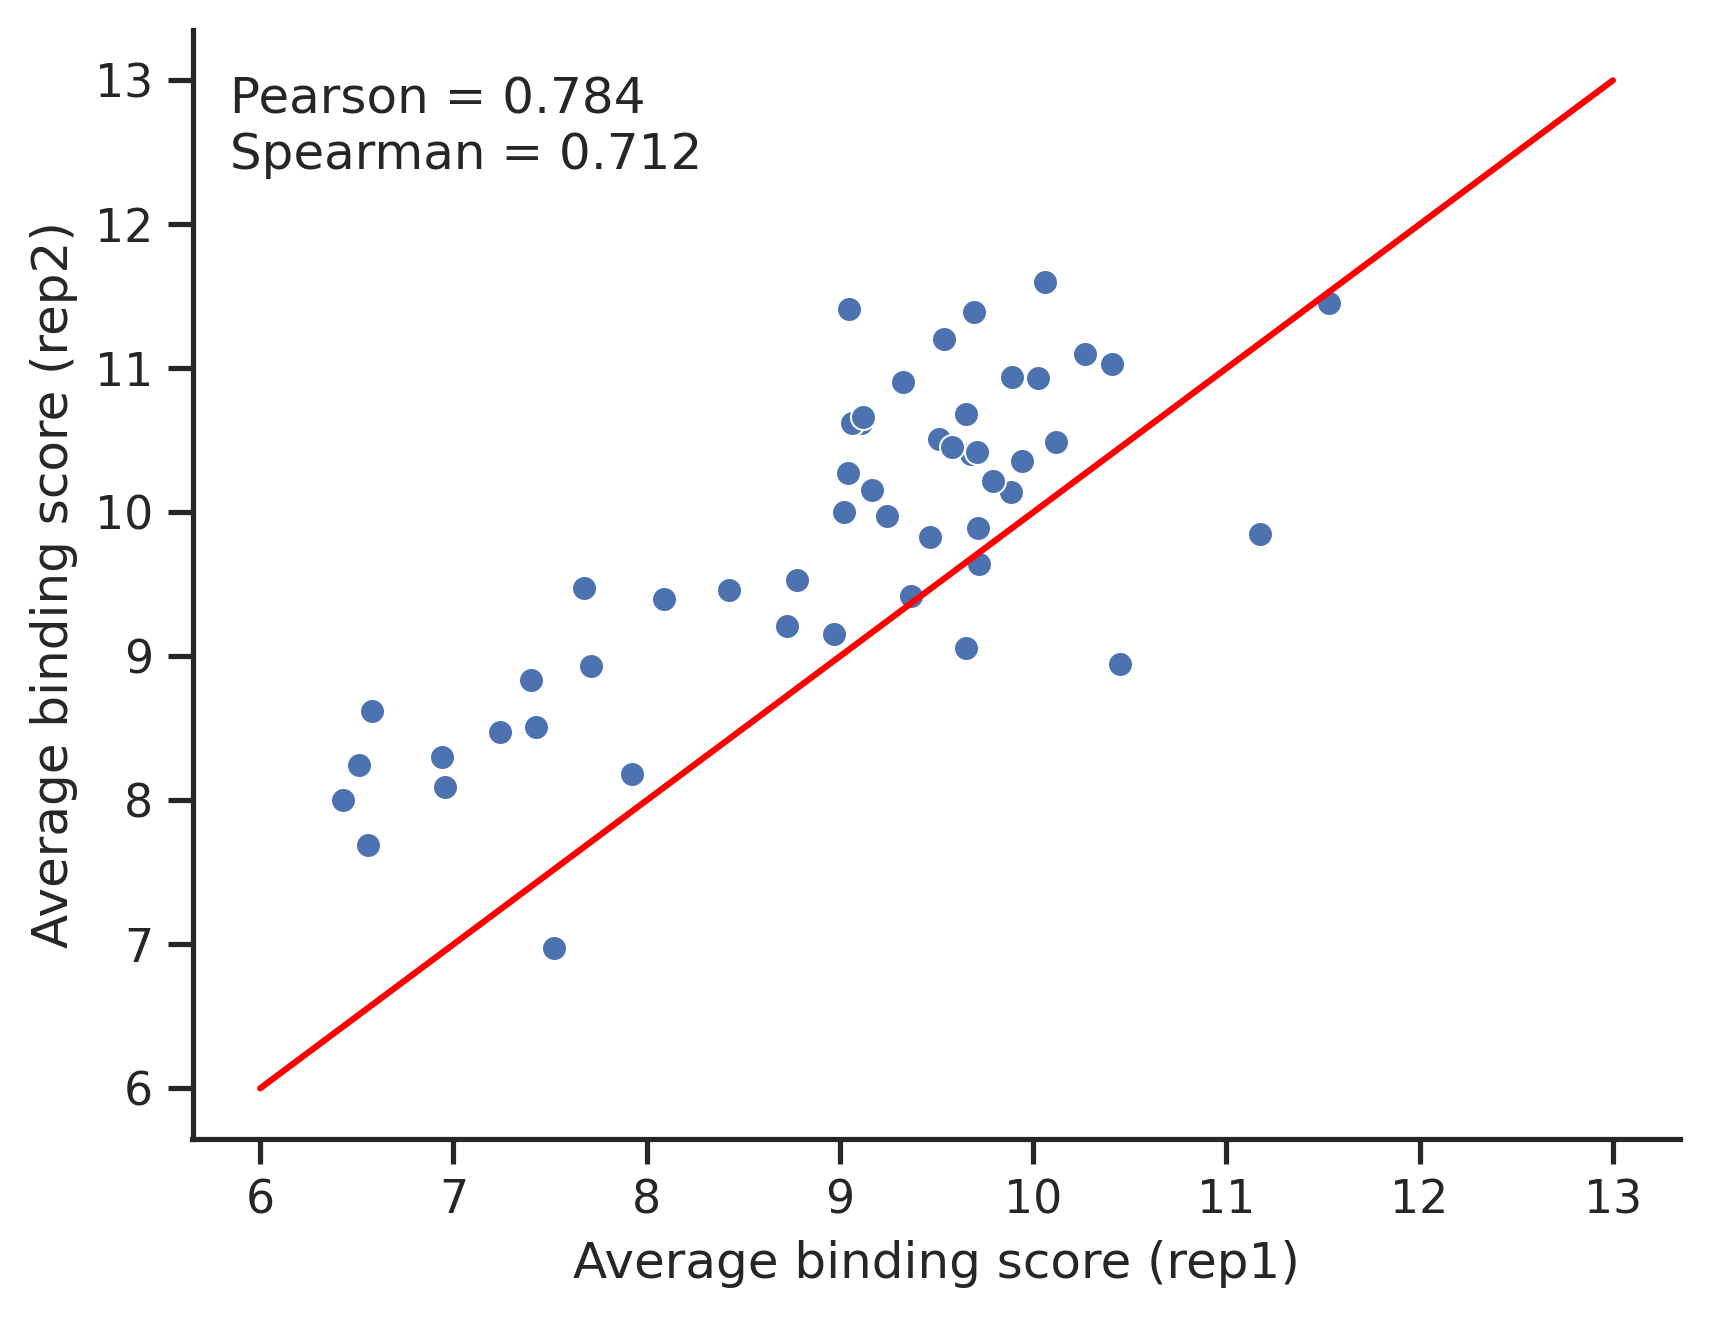

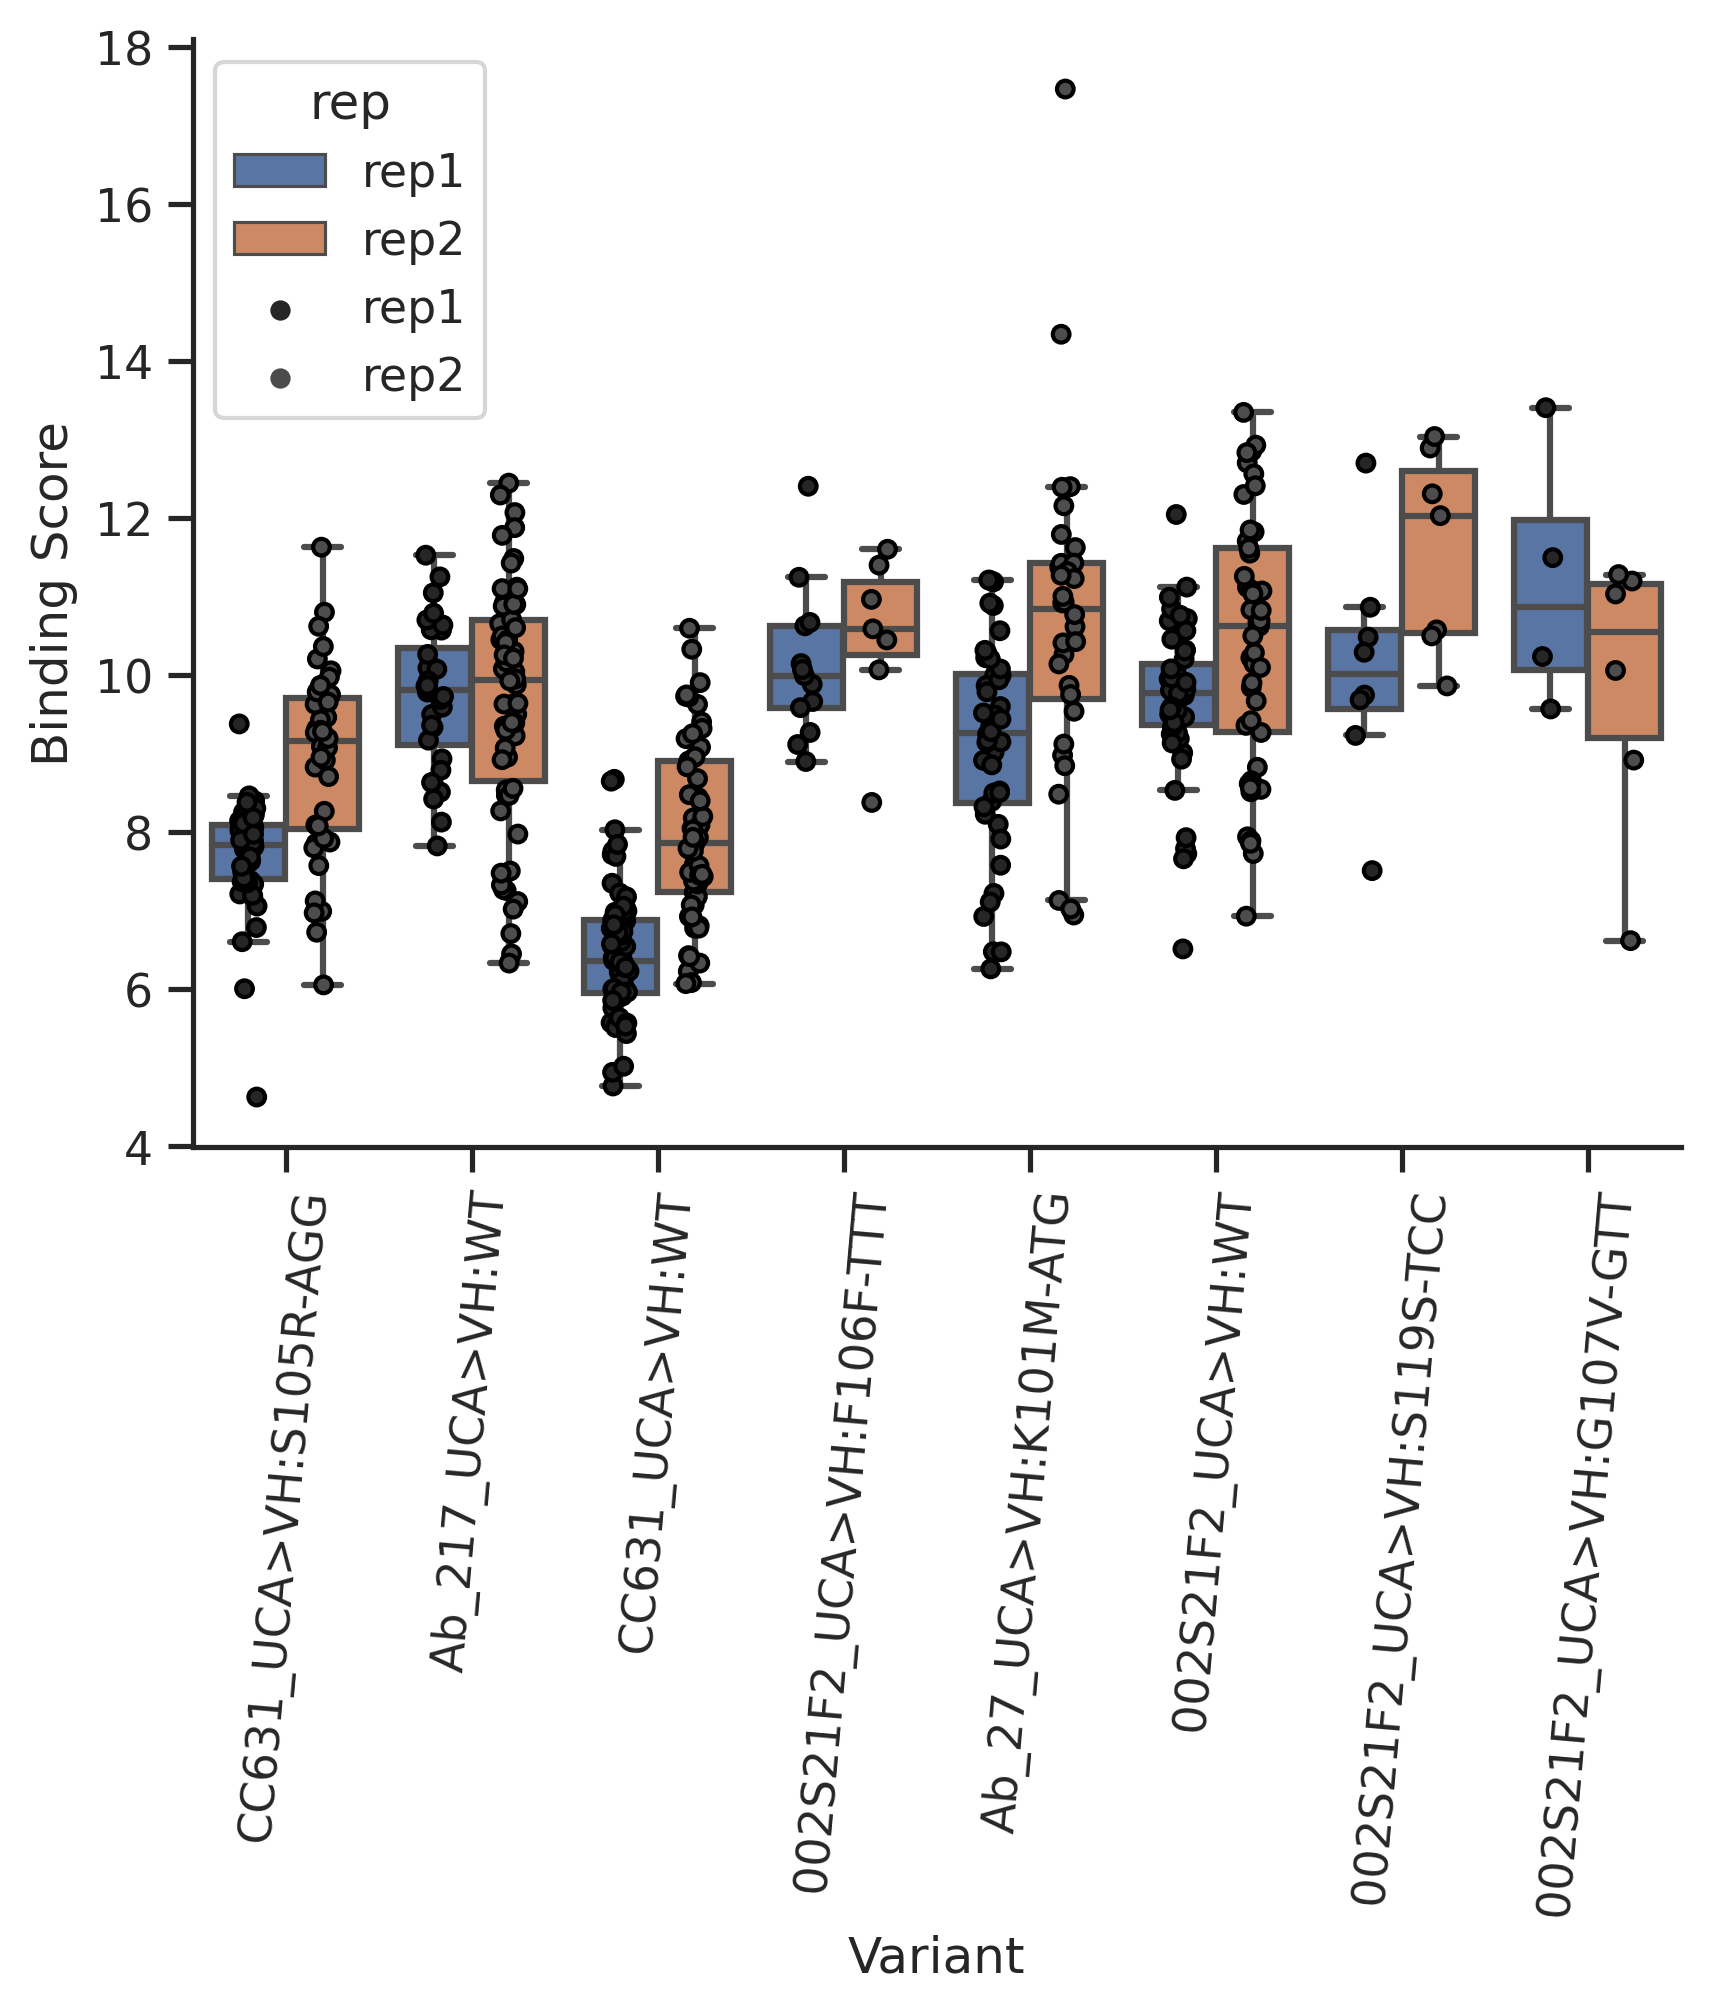

In [29]:
df1 = pd.read_csv("/projects/brpe7306/fab-library-barcoding/CDRH3_Output/bc_pij_top10bins_rep1.csv")[
    ['Barcode', 'Variant', 'Gene', 'num_mutations', 'Silent', 'Score']
]
df2 = pd.read_csv("/projects/brpe7306/fab-library-barcoding/CDRH3_Output/bc_pij_top10bins_rep2.csv")[
    ['Barcode', 'Variant', 'Gene', 'num_mutations', 'Silent', 'Score']
]
df1['rep'] = 'rep1'
df2['rep'] = 'rep2'
df_plot = pd.concat([df1, df2])
df_plot = df_plot[df_plot['Gene'] != "C118_UCA"]
df_plot['is_WT'] = df_plot.apply(lambda row: row['num_mutations'] == 0 or (row['num_mutations'] == 1 and row['Silent']), axis=1)
avg_df = df_plot.groupby(['Variant', 'rep', 'Gene'], as_index=False)['Score'].agg(['mean', 'count']).reset_index()
plt.figure(figsize=(3.7,4))
x = "Gene"
y = "Score"
hue = 'rep'
hue_order=['rep1', 'rep2']
order = ["CC631_UCA", "Ab_27_UCA", "Ab_217_UCA", "002S21F2_UCA"]
pairs=[((ab, 'rep1'), (ab, 'rep2')) for ab in order]
ax = sns.boxplot(data=df_plot, x=x, y=y, hue=hue, hue_order=hue_order)
annot = Annotator(ax, pairs, data=df_plot, x=x, y=y, order=order, hue=hue, hue_order=hue_order)
annot.configure(test='t-test_ind', text_format='star', loc='outside', verbose=2)
annot.apply_test()
# ax, test_results = annot.annotate()
plt.rcParams['legend.markerscale'] = 0.5
plt.legend(loc='upper left', borderaxespad=0.5, prop={'size': 6})
plt.ylabel("Binding Score")
plt.xlabel("Gene")
plt.xticks(rotation=55)
plt.tight_layout()
plt.savefig("Score.png")
plt.show()
plt.clf()

df_pivot = avg_df.pivot(index='Variant', columns='rep', values=['mean', 'count'])
df_pivot = df_pivot.dropna()
print(df_pivot)
df_pivot = df_pivot[(df_pivot[('count', 'rep1')] > 1) & (df_pivot[('count', 'rep2')] > 1)]
print(df_pivot)
for x, y in zip(df_pivot[('count', 'rep1')], df_pivot[('count', 'rep2')]):
    print(x,y)
sns.scatterplot(x=('mean', 'rep1'), y=('mean', 'rep2'), data=df_pivot)
filtered_df = df_pivot[abs(df_pivot[('mean', 'rep1')] - df_pivot[('count', 'rep2')]) > 2]
filtered_df.to_csv("outliers.csv", float_format='%.4f')
r, p = stats.pearsonr(df_pivot[('mean', 'rep1')], df_pivot[('mean', 'rep2')])
spearmanr, pval = stats.spearmanr(df_pivot[('mean', 'rep1')], df_pivot[('mean', 'rep2')])
plt.plot([6, 13], [6, 13], color='red')
plt.text(0.025, 0.925, 'Pearson = {:.3f}'.format(r), transform=plt.gca().transAxes)
plt.text(0.025, 0.875, 'Spearman = {:.3f}'.format(spearmanr), transform=plt.gca().transAxes)
plt.xlabel("Average binding score (rep1)")
plt.ylabel("Average binding score (rep2)")
plt.savefig("bc_rep_compare.png")
plt.show()
plt.clf()
barcode_counts = df_plot.groupby('Variant')['Barcode'].nunique()
barcode_counts = barcode_counts.sort_values(ascending=False)
picked = barcode_counts.head(8)
picked = picked.index.tolist()
sns.boxplot(data=df_plot[df_plot['Variant'].isin(picked)], x='Variant', y='Score', hue='rep', showfliers=False)
sns.stripplot(data=df_plot[df_plot['Variant'].isin(picked)], x='Variant', y='Score', hue='rep', linewidth=1, edgecolor='black', \
              dodge=True, size=4, color=".3")
plt.xticks(rotation=85)
plt.ylabel("Binding Score")
plt.savefig("bc_rep_compare_box.png")
plt.show()

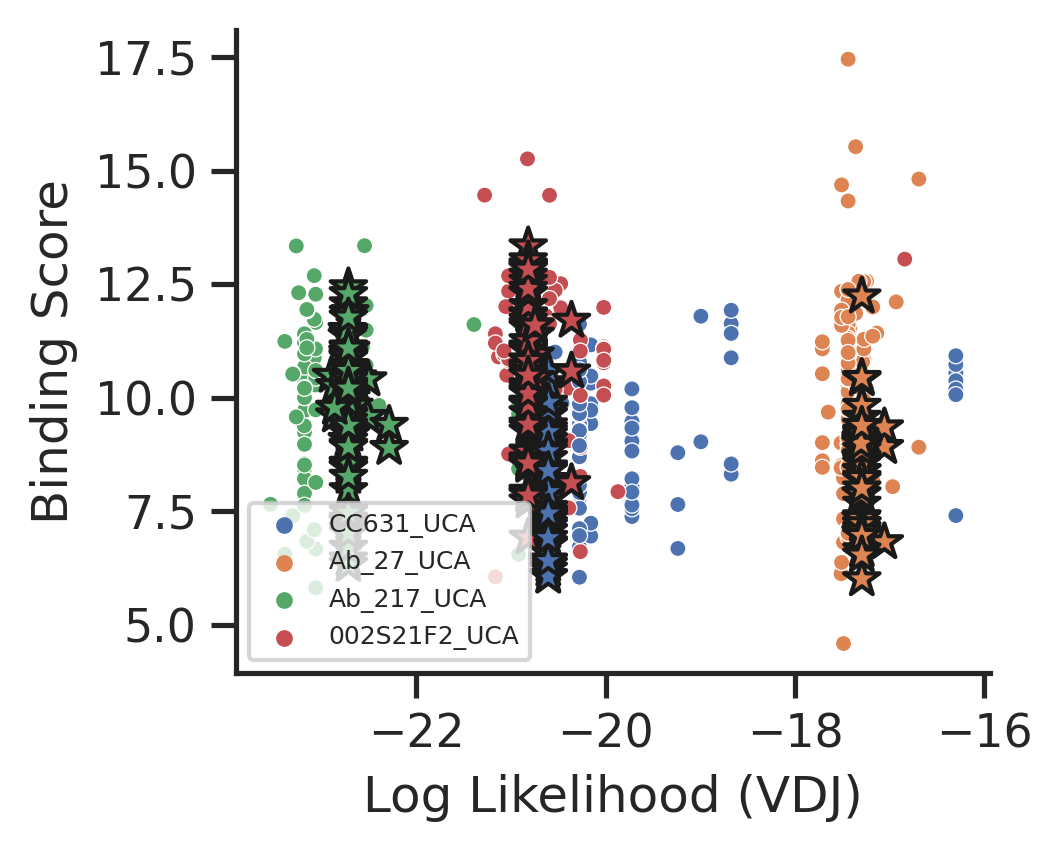

In [11]:
probs_df = pd.read_csv("/projects/brpe7306/antiberty/pgen_pll.csv")
df_plot = pd.merge(merged_df, probs_df, on=["Variant"], how="left")
df_plot = df_plot[df_plot['Gene'] != "C118_UCA"]
df_plot['is_WT'] = df_plot.apply(lambda row: row['num_mutations'] == 0 or (row['num_mutations'] == 1 and row['Silent']), axis=1)
plt.figure(figsize=(3.7,3))
hue_order = ["CC631_UCA", "Ab_27_UCA", "Ab_217_UCA", "002S21F2_UCA"]
sns.scatterplot(data=df_plot[df_plot['is_WT'] == False], x="LL", y="Score", hue='Gene', s=15, hue_order=hue_order)
plt.rcParams['legend.markerscale'] = 0.5
plt.legend(loc='lower left', borderaxespad=0.5, prop={'size': 6})
sns.scatterplot(data=df_plot[df_plot['is_WT'] == True], x="LL", y="Score", hue='Gene', marker="*", ec='k', linewidth=1, s=80, legend=False, hue_order=hue_order)
plt.ylabel("Binding Score")
plt.xlabel("Log Likelihood (VDJ)")
plt.tight_layout()
#plt.savefig("pllvScore_rep2.png")
plt.show()

In [26]:
from scipy import stats
x = np.array([1, 2, 3, 4, 5])
y = np.array([5, 6, 7, 8, 7])

# Step 3: Calculate the Spearman correlation coefficient and the p-value
correlation, p = stats.spearmanr(x, y)
print(correlation)

0.8207826816681233
